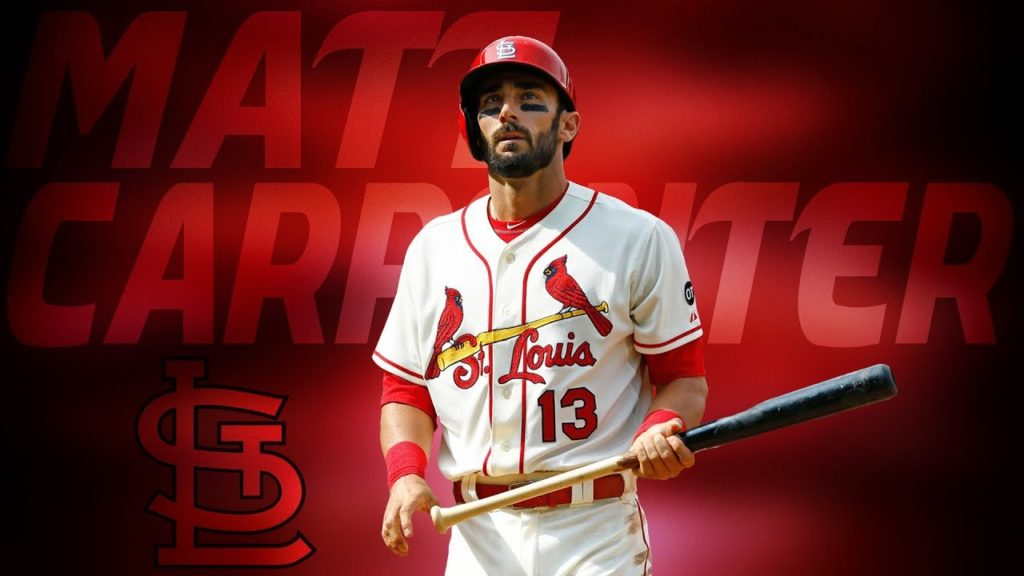

In [75]:
from IPython.display import Image
Image("mc.jpg")

In [76]:
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

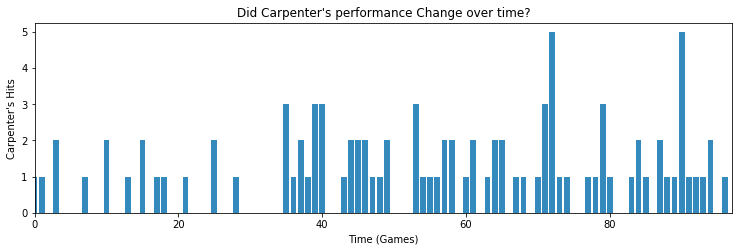

In [78]:
figsize(12.5, 3.5)
count_data = pd.read_csv("data/MC_Hits.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data['Hits'], color="#348ABD")
plt.xlabel("Time (Games)")
plt.ylabel("Carpenter's Hits")
plt.title("Did Carpenter's performance Change over time?")
plt.xlim(0, n_count_data);

In [49]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data['Hits'].mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [53]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [54]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data['Hits'])

In [55]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:07<00:00, 7622.94draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [56]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/home/nick/miniconda3/envs/pymc3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


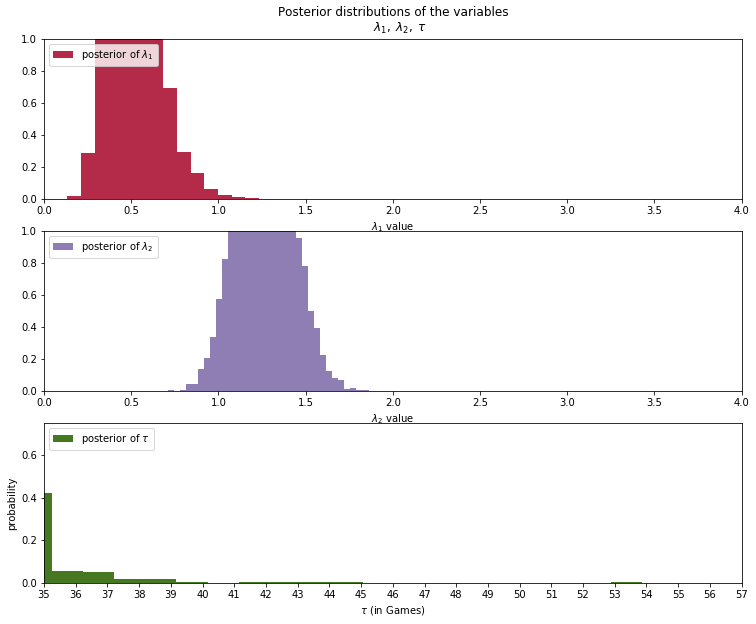

In [79]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=50, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([0, 4])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=50, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 4])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-40])
plt.xlabel(r"$\tau$ (in Games)")
plt.ylabel("probability");

There is clearly a switch between Lambda 1 and Lambda 2, where Carpenter's hits per games improved. The posterior probability associated with Tau tells us this happened with about a 42% probability at game 35. 

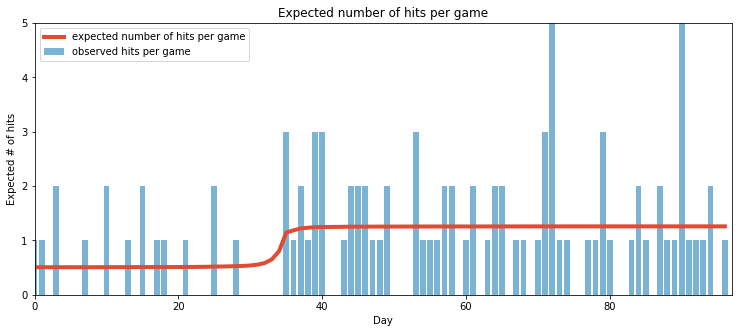

In [70]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_hits_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_hits_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_hits_per_day, lw=4, color="#E24A33",
         label="expected number of hits per game")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # of hits")
plt.title("Expected number of hits per game")
plt.ylim(0, 5)
plt.bar(np.arange(len(count_data)), count_data['Hits'], color="#348ABD", alpha=0.65,
        label="observed hits per game")

plt.legend(loc="upper left");

In [71]:
#type your code here.
print(lambda_1_samples.mean())
print(lambda_2_samples.mean())

0.5074111681455136
1.2592285166542108
